In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from pathlib import Path

import notebooks.config as experim_cfg

# Kmeans for countries clustering

In [3]:
data_path = Path('data', 'external', 'owid-covid-data.csv')
covid_data = pd.read_csv(data_path, index_col=0)
covid_data = covid_data[~covid_data.iso_code.str.contains('OWID')]
covid_data['date'] = pd.to_datetime(covid_data['date'])

In [4]:
unique_countries_stats_path = Path(
    'data',
    'interim',
    f'unique_countries_({experim_cfg.MORTALITY_INDICATOR}).csv',
)
unique_countries = pd.read_csv(unique_countries_stats_path, index_col=0)

In [5]:
well_being_indicators = [
    'aged_70_older',
    'aged_65_older',
    'gdp_per_capita',
    'extreme_poverty',
    'hospital_beds_per_thousand',
    'human_development_index',
    'median_age',
    'population_density',
]

for indicator in well_being_indicators:
    assert (covid_data.groupby(['iso_code'])[indicator].nunique() < 2).all(), indicator
# There is only one unique value for each well-being indicators in each country

## Prepare countries dataset

In [6]:
countries_df_for_cluster = covid_data.groupby(['iso_code'], as_index=False,)[well_being_indicators].first()

In [7]:
# Standartize the data
scaler = MinMaxScaler()
countries_df_for_cluster.loc[:, well_being_indicators] = scaler.fit_transform(
    countries_df_for_cluster[well_being_indicators]
)

In [8]:
countries_df_for_cluster[well_being_indicators] = countries_df_for_cluster[well_being_indicators].fillna(
    countries_df_for_cluster[well_being_indicators].median()
)

## Choose k for clustering

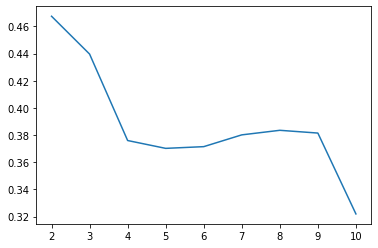

In [9]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
kmax = 10

for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(countries_df_for_cluster.loc[:, well_being_indicators])
    labels = kmeans.labels_
    silhouette_scores.append(
        silhouette_score(
            countries_df_for_cluster.loc[:, well_being_indicators],
            labels,
        )
    )

plt.figure()
plt.plot(
    np.linspace(2, 10, 9),
    silhouette_scores,
)

In [10]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=500,
    random_state=42
)
kmeans.fit(countries_df_for_cluster.loc[:, well_being_indicators])

KMeans(init='random', max_iter=500, n_clusters=3, random_state=42)

In [11]:
countries_df_for_cluster['cluster'] = kmeans.labels_

## PCA for visualization

In [12]:
pca = PCA(n_components=2)
countries_df_for_cluster.loc[:,['pc1', 'pc2']] = pca.fit_transform(
    countries_df_for_cluster.loc[:, well_being_indicators]
)
pca.explained_variance_ratio_.sum()

0.814835294889393

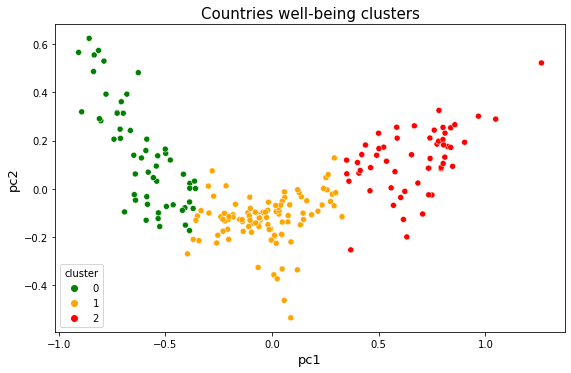

In [13]:
plt.figure(figsize=(8,5))
sns.color_palette()
sns.scatterplot(
    data=countries_df_for_cluster,
    x='pc1',
    y='pc2',
    hue='cluster',
    palette=['green','orange','red']
)

plt.tight_layout()
plt.xlabel('pc1', size=13)
plt.ylabel('pc2', size=13)
plt.title('Countries well-being clusters', size=15)
plt.savefig(
    experim_cfg.get_pic_save_path(plot_type='kmeans_pca'),
    transparent=True,
    dpi=500,
    bbox_inches='tight'
)

In [14]:
cluster_mapper = countries_df_for_cluster.set_index('iso_code')['cluster']

In [15]:
cluster_mapper

iso_code
ABW    2
AFG    0
AGO    0
AIA    1
ALB    2
      ..
WSM    1
YEM    0
ZAF    1
ZMB    0
ZWE    0
Name: cluster, Length: 229, dtype: int32

# DBSCAN clustering


In [16]:
cluster_data = covid_data.groupby('iso_code').first()[well_being_indicators]
cluster_data = cluster_data[cluster_data.isna().sum(1) < 3]

## Filling the gaps in data

In [17]:
cluster_data.loc[cluster_data.aged_70_older.isna(), 'aged_70_older'] = cluster_data.loc[
    cluster_data.aged_70_older.isna(),
    'aged_65_older'
] * np.mean(cluster_data.aged_70_older / cluster_data.aged_65_older)

cluster_data['gdp_per_capita'] = cluster_data['gdp_per_capita'].fillna(
    cluster_data['gdp_per_capita'].median()
)

cluster_data['gdp_q'] = pd.qcut(cluster_data['gdp_per_capita'], 10)

cluster_data['hospital_beds_per_thousand'] = cluster_data.groupby('gdp_q')[
    'hospital_beds_per_thousand'
].apply(lambda x: x.fillna(x.mean()))
cluster_data['extreme_poverty'] = cluster_data.groupby('gdp_q')[
    'extreme_poverty'
].apply(lambda x: x.fillna(x.mean()))

In [18]:
# Standartize the data
scaler = MinMaxScaler()
cluster_data.loc[:, well_being_indicators] = scaler.fit_transform(
    cluster_data[well_being_indicators]
)

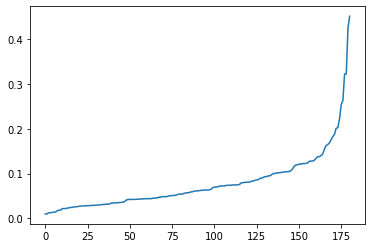

In [19]:
indicators_for_clusterization = [
    'aged_65_older',
    'gdp_per_capita',
    'hospital_beds_per_thousand',
    'population_density',
    'median_age',
]

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(cluster_data[indicators_for_clusterization])
distances, indices = nbrs.kneighbors(cluster_data[indicators_for_clusterization])

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [20]:
epsilon = distances[163]

In [21]:
clusterizer = DBSCAN(eps=epsilon, min_samples=8)
clusterizer.fit(cluster_data[indicators_for_clusterization])

clusters = clusterizer.labels_

clusters -= np.min(clusters)

cluster_data['cluster'] = clusters
cluster_data = cluster_data.drop(columns='gdp_q')

In [22]:
pca = PCA(n_components=2)
cluster_data.loc[:,['pc1', 'pc2']] = pca.fit_transform(
    cluster_data.loc[:, indicators_for_clusterization]
)
pca.explained_variance_ratio_.sum()

0.8689755762250472

Text(0.5, 1.0, 'Countries well-being clusters')

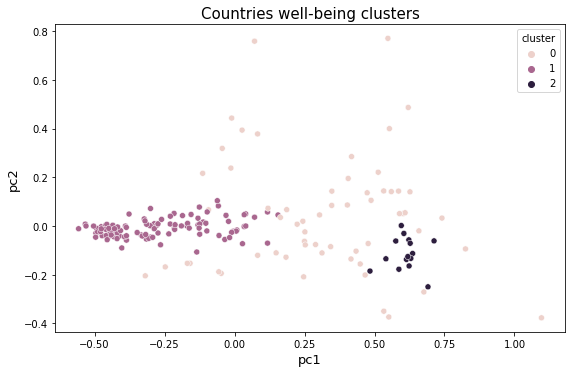

In [23]:
plt.figure(figsize=(8,5))
sns.color_palette()
sns.scatterplot(
    data=cluster_data,
    x='pc1',
    y='pc2',
    hue='cluster',
#     palette=['green','orange','red']
)

plt.tight_layout()
plt.xlabel('pc1', size=13)
plt.ylabel('pc2', size=13)
plt.title('Countries well-being clusters', size=15)

<AxesSubplot:xlabel='gdp_per_capita', ylabel='aged_65_older'>

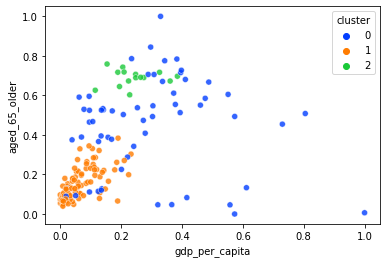

In [24]:
sns.scatterplot(
    x=cluster_data.gdp_per_capita,
    y=cluster_data.aged_65_older,
    hue=cluster_data.cluster,
    palette='bright',
    alpha=0.8
)

<AxesSubplot:xlabel='aged_65_older', ylabel='population_density'>

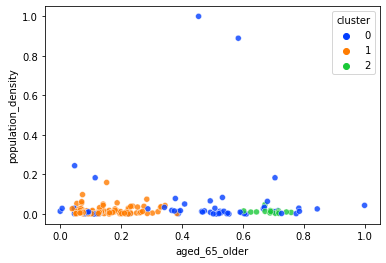

In [25]:
sns.scatterplot(
    x=cluster_data.aged_65_older,
    y=cluster_data.population_density,
    hue=cluster_data.cluster,
        palette='bright',
    alpha=0.8
)

<AxesSubplot:xlabel='human_development_index', ylabel='hospital_beds_per_thousand'>

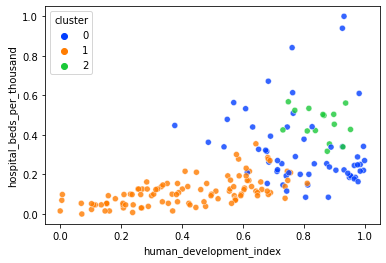

In [26]:
sns.scatterplot(
    x=cluster_data.human_development_index,
    y=cluster_data.hospital_beds_per_thousand,
    hue=cluster_data.cluster,
        palette='bright',
    alpha=0.8
)

In [27]:
cluster_data.groupby(['cluster']).mean()

aged_70_older  aged_65_older  gdp_per_capita  extreme_poverty  \
cluster                                                                  
0             0.422956       0.441376        0.291568         0.017014   
1             0.133817       0.143399        0.059204         0.247176   
2             0.679288       0.689970        0.241969         0.015296   

         hospital_beds_per_thousand  human_development_index  median_age  \
cluster                                                                    
0                          0.324877                 0.803375    0.674723   
1                          0.111976                 0.419317    0.277290   
2                          0.457066                 0.855417    0.851964   

         population_density       pc1       pc2  
cluster                                          
0                  0.057324  0.317622  0.042129  
1                  0.016513 -0.266245 -0.007854  
2                  0.012992  0.610976 -0.113016

In [28]:
dbscan_cluster_mapper = cluster_data['cluster']

In [29]:
covid_data['cluster'] = covid_data.iso_code.map(dbscan_cluster_mapper)
covid_data['cluster'].value_counts()

1.0    95820
0.0    55698
2.0    14052
Name: cluster, dtype: int64

## Clusterization results

In [30]:
unique_countries['cluster'] = unique_countries.iso_code.map(dbscan_cluster_mapper)
unique_countries['cluster'].value_counts()

0.0    35
2.0    15
1.0    14
Name: cluster, dtype: int64

It's obvious that there are only 2 out of 3 clusters in the dataframe. (for excess deaths and vaccination)

In [31]:
unique_countries.groupby(['cluster']).mean()

aged_65_older  gdp_per_capita  extreme_poverty  \
cluster                                                   
0.0          15.324171    39700.647471         0.864000   
1.0           6.878000    12972.061714         5.036364   
2.0          19.017667    28796.040933         1.270000   

         hospital_beds_per_thousand  human_development_index  median_age  \
cluster                                                                    
0.0                        4.482529                 0.879629   39.982857   
1.0                        1.851429                 0.751214   29.342857   
2.0                        6.019000                 0.875600   43.300000   

         population_density  corr_vac_exc_deaths  
cluster                                           
0.0              586.527886             0.149016  
1.0              114.254643            -0.418565  
2.0              104.796067            -0.048423

In [32]:
overall_clusterization = covid_data.groupby(['iso_code'], as_index=False,)[
    [
        'aged_65_older',
        'human_development_index',
        'hospital_beds_per_thousand',
        'gdp_per_capita',
        'extreme_poverty',
        'cluster',
    ]
].first()

In [33]:
overall_clusterization.groupby(['cluster'])[
    [
        'aged_65_older',
        'human_development_index',
        'hospital_beds_per_thousand',
        'gdp_per_capita',
        'extreme_poverty',
    ]
].mean().round(3)

aged_65_older  human_development_index  hospital_beds_per_thousand  \
cluster                                                                       
0.0             12.578                    0.846                       4.349   
1.0              4.859                    0.630                       1.549   
2.0             19.018                    0.876                       6.019   

         gdp_per_capita  extreme_poverty  
cluster                                   
0.0           34948.594            1.745  
1.0            7545.150           22.027  
2.0           28796.041            1.270

In [34]:
if unique_countries['cluster'].nunique() == 2:
    COLOR_PALETTE = ['green','red']
else:
    COLOR_PALETTE = ['green','red', 'orange']

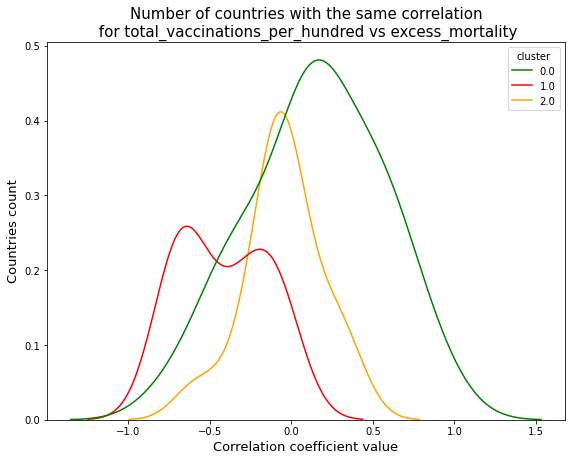

In [35]:
plt.figure(figsize=(8,6))
sns.kdeplot(
    data=unique_countries,
    x='corr_vac_exc_deaths',
    hue='cluster',
    palette=COLOR_PALETTE
)

plt.tight_layout()
plt.xlabel('Correlation coefficient value', size=13)
plt.ylabel('Countries count', size=13)
plt.title(
    f'Number of countries with the same correlation\n for {experim_cfg.VACCINATION_INDICATOR} vs {experim_cfg.MORTALITY_INDICATOR}',
    size=15,
)
plt.savefig(
    experim_cfg.get_pic_save_path(plot_type='corr_per_cluster'),
    transparent=True,
    dpi=500,
    bbox_inches='tight'
)

In [36]:
# Compute vaccination start date
first_vac_index = covid_data[
    ~covid_data.people_vaccinated.isna()
]
vac_start_date_mapper = first_vac_index.groupby(['iso_code'])['date'].first()

unique_countries['vac_start_date'] = unique_countries.iso_code.map(vac_start_date_mapper)

In [37]:
# Compute vaccination-death data points
country_measures_count = covid_data.groupby(['iso_code'])['continent'].count()
unique_countries['measures_count'] = unique_countries.iso_code.map(country_measures_count)

vac_vs_excess_mort = covid_data[
    [experim_cfg.VACCINATION_INDICATOR, experim_cfg.MORTALITY_INDICATOR, 'iso_code']
].dropna()

vac_vs_excess_mort['cluster'] = vac_vs_excess_mort['iso_code'].map(cluster_mapper)

corr_quadrant_mapper = unique_countries.set_index('iso_code')['corr_quadrant']
vac_vs_excess_mort['corr_quadrant'] = vac_vs_excess_mort['iso_code'].map(corr_quadrant_mapper)

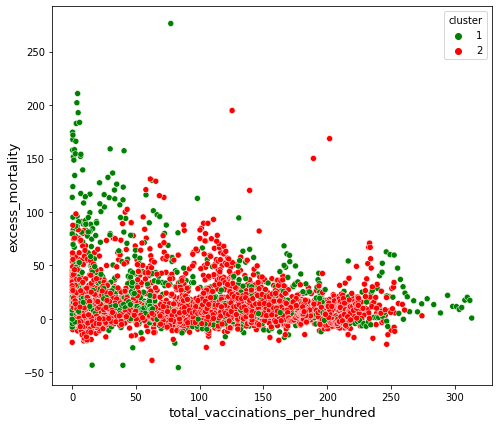

In [38]:
if vac_vs_excess_mort['cluster'].nunique() == 2:
    COLOR_PALETTE = ['green','red']
else:
    COLOR_PALETTE = ['green','red', 'orange']

plt.figure(figsize=(7,6))

sns.scatterplot(
    data=vac_vs_excess_mort,
    x=experim_cfg.VACCINATION_INDICATOR,
    y=experim_cfg.MORTALITY_INDICATOR,
    hue='cluster',
    palette=COLOR_PALETTE
)

plt.tight_layout()
plt.xlabel(f'{experim_cfg.VACCINATION_INDICATOR}', size=13)
plt.ylabel(f'{experim_cfg.MORTALITY_INDICATOR}', size=13)
plt.savefig(
    experim_cfg.get_pic_save_path(plot_type='scatter'),
    transparent=True,
    dpi=500,
)

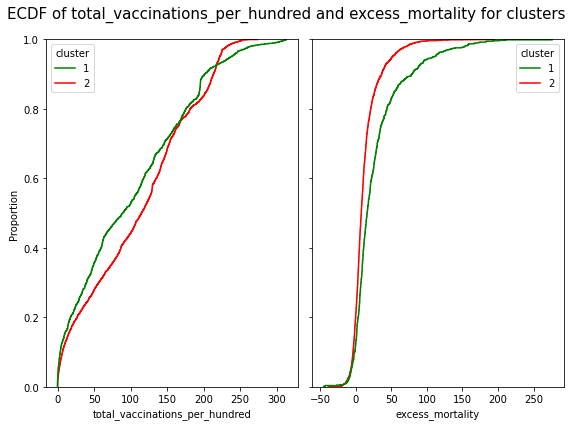

In [39]:
fig, ax = plt.subplots(1,2, figsize=(8, 6), sharey=True)
# plt.figure(figsize=(5,6))
sns.ecdfplot(
    data=vac_vs_excess_mort,
    x=experim_cfg.VACCINATION_INDICATOR,
    hue='cluster',
    ax=ax[0],
    palette=COLOR_PALETTE
)
 

sns.ecdfplot(
    data=vac_vs_excess_mort,
    x=experim_cfg.MORTALITY_INDICATOR,
    hue='cluster',
    ax=ax[1],
    palette=COLOR_PALETTE
)
fig.suptitle(f'ECDF of {experim_cfg.VACCINATION_INDICATOR} and {experim_cfg.MORTALITY_INDICATOR} for clusters', size=15)

plt.tight_layout()
plt.savefig(
    experim_cfg.get_pic_save_path(plot_type='ECDF'),
    transparent=True,
    dpi=500,
)

<AxesSubplot:xlabel='excess_mortality', ylabel='Proportion'>

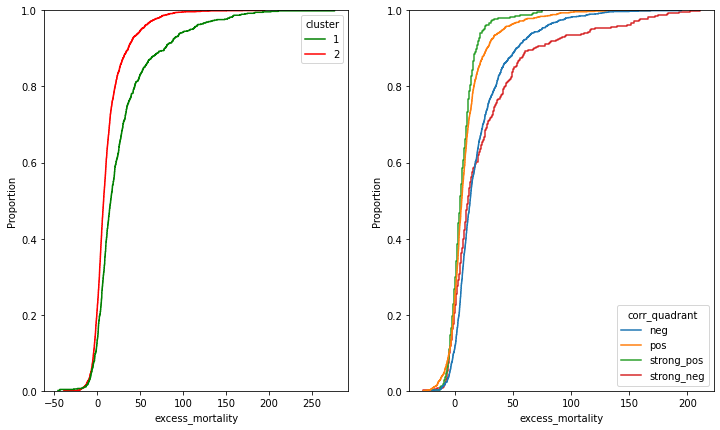

In [40]:
fig, ax = plt.subplots(1,2, figsize=(12, 7))
sns.ecdfplot(
    data=vac_vs_excess_mort,
    x=experim_cfg.MORTALITY_INDICATOR,
    hue='cluster',
    ax=ax[0],
    palette=COLOR_PALETTE
)
sns.ecdfplot(
    data=vac_vs_excess_mort,
    x=experim_cfg.MORTALITY_INDICATOR,
    hue='corr_quadrant',
    ax=ax[1]
)

<AxesSubplot:xlabel='excess_mortality', ylabel='Count'>

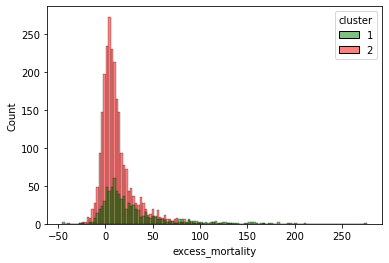

In [41]:
sns.histplot(
    data=vac_vs_excess_mort,
    x=experim_cfg.MORTALITY_INDICATOR,
    hue='cluster',
    palette=COLOR_PALETTE
)

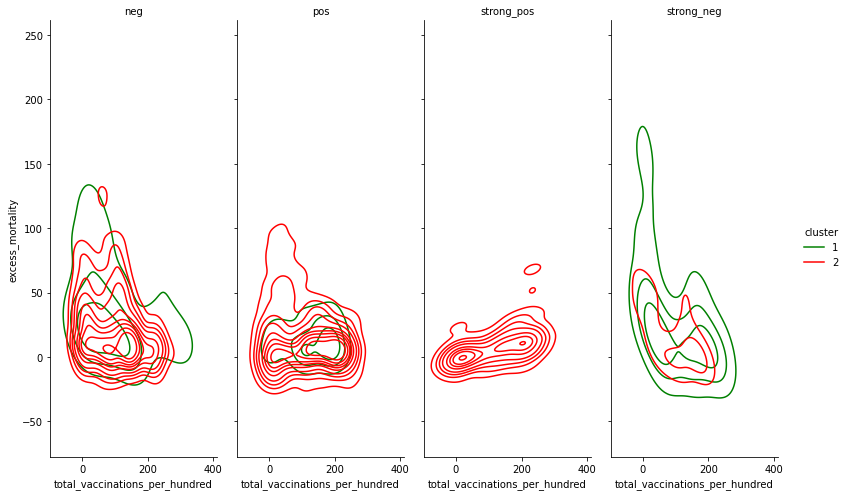

In [42]:
g = sns.displot(
    data=vac_vs_excess_mort,
    x=experim_cfg.VACCINATION_INDICATOR,
    y=experim_cfg.MORTALITY_INDICATOR,
    hue="cluster",
    col="corr_quadrant",
    kind="kde",
    height=7,
    aspect=.4,
    palette=COLOR_PALETTE,
)
g.set_axis_labels(experim_cfg.VACCINATION_INDICATOR, experim_cfg.MORTALITY_INDICATOR)
g.set_titles("{col_name}")

In [43]:
# Save clusterization results
unique_countries.to_csv(unique_countries_stats_path, index=False)